# **Dysgraphia Classification using VGG16 Architecture with Sobel and Roberts Edge Detection in an Offline Handwriting Analysis**



---



In [ ]:
# Installation

!pip install pydot pydotplus
!pip install --user opencv-python-headless
!pip install --upgrade opencv-python-headless
!pip install --upgrade tensorflow
!pip install mahotas
!pip install optuna
!pip install tabulate
!pip install imageio
!pip install opencv-python
!pip install dask
!pip install tk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.

In [ ]:
# Imports

from google.colab import drive
from pathlib import Path

from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, regularizers
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image, ImageEnhance, ImageFilter

import matplotlib.pyplot as plt
import tensorflow as tf
import optuna
import seaborn as sns
import cv2
import imghdr
import os
import numpy as np
import pandas as pd

from tkinter import simpledialog, messagebox
from PIL import Image, ImageEnhance
from dask import bag, diagnostics
from PIL import Image
from  imageio import imread
from tabulate import tabulate

import hashlib
import time
import tkinter as tk
import keras
import optuna



---



## ✅**Checking the Dataset**

In [ ]:
# Mounting the drive

drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
 # Checking file types

data_dir = "/content/drive/Shared drives/CS FILES/dysgraphia_dataset/"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

## ✅**Exploratory Data Analysis**

In [ ]:
# Define the directory paths
low_potential_dir = data_dir+"/Low Potential Dysgraphia"
potential_dir = data_dir+"/Potential Dysgraphia"

# Get the number of files in each directory
number_classes = {
    'Low Potential Dysgraphia': len(os.listdir(low_potential_dir)),
    'Potential Dysgraphia': len(os.listdir(potential_dir))
}

print(number_classes)

{'Low Potential Dysgraphia': 135, 'Potential Dysgraphia': 114}


In [ ]:
# @title Number of Images by Class

# plt.bar(number_classes.keys(), number_classes.values(), width = .5,  color='pink');
# plt.title("Number of Images by Class");
# plt.xlabel('Class Name');
# plt.ylabel('Number of Images');

# # Customizing y-axis interval to be 5
# plt.yticks(range(0, max(number_classes.values()) + 1, 10))

# # Setting a smaller range for the y-axis
# plt.ylim(0, 140)

# plt.show()

In [ ]:
# @title Analyzing Pixel Sizes

# directories = {
#     'Low Potential Dysgraphia': low_potential_dir,
#     'Potential Dysgraphia': potential_dir
# }

# def get_dims(file_path):
#     # Check if the path is a file before attempting to open it
#     if os.path.isfile(file_path):
#         img = Image.open(file_path)
#         arr = np.array(img)
#         if len(arr.shape) == 2:
#             h, w = arr.shape
#             d = 1
#         elif len(arr.shape) == 3:
#             h, w, d = arr.shape
#         else:
#             raise ValueError("Unsupported image format")
#         return h, w, d
#     else:
#         return None  # Or handle the directory case differently

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# i = 0
# for n, d in directories.items():
#     file_list = [os.path.join(d, f) for f in os.listdir(d) if os.path.isfile(os.path.join(d, f))] # Filter out directories
#     dims = bag.from_sequence(file_list).map(get_dims)
#     with diagnostics.ProgressBar():
#         dims = dims.compute()

#     # Remove None values from dims, which represent directories
#     dims = [dim for dim in dims if dim is not None]

#     dim_df = pd.DataFrame(dims, columns=['height', 'width', 'depth'])
#     sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

#     axes[i].scatter(x='width', y='height', data=sizes, color='#FF1493')
#     axes[i].set_title(f'Image Sizes (pixels) | {n}')
#     i += 1

# plt.tight_layout()
# plt.show()

## ✅**Image Resizing**

In [ ]:
# @title Resizing

# # Resizing and Adding Padding
# def pad_and_resize(image, target_size=(224, 224)):
#     width, height = image.size
#     longer_side = max(width, height)
#     horizontal_padding = (longer_side - width) // 2
#     vertical_padding = (longer_side - height) // 2

#     padded_image = Image.new(image.mode, (longer_side, longer_side), color='black')
#     padded_image.paste(image, (horizontal_padding, vertical_padding))

#     # Resize the padded image to the target size with anti-aliasing
#     padded_image_resized = padded_image.resize(target_size)

#     return padded_image_resized

# # Output directory for saving the processed images
# resized_dir = "/content/drive/Shared drives/CS FILES/dysgraphia_dataset_resized/"

# # Create the output directory if it doesn't exist
# os.makedirs(resized_dir, exist_ok=True)

# # Loop through each subdirectory and process images
# for root, _, filenames in os.walk(data_dir):
#     for filename in filenames:
#         if filename.endswith(".jpg") or filename.endswith(".png"):
#             # Load the image
#             image_path = os.path.join(root, filename)
#             original_image = Image.open(image_path)

#             # Pad and resize the image
#             final_image = pad_and_resize(original_image)

#             # Save the final resized image
#             relative_output_path = os.path.relpath(image_path, data_dir)
#             output_path = os.path.join(resized_dir, relative_output_path)
#             os.makedirs(os.path.dirname(output_path), exist_ok=True)
#             final_image.save(output_path)

In [ ]:
resized_dir = "/content/drive/Shared drives/CS FILES/dysgraphia_dataset_resized/"
low_potential_dir = resized_dir+"/Low Potential Dysgraphia"
potential_dir = resized_dir+"/Potential Dysgraphia"

number_classes = {
    'Low Potential Dysgraphia': len(os.listdir(low_potential_dir)),
    'Potential Dysgraphia': len(os.listdir(potential_dir))
}

print(number_classes)

{'Low Potential Dysgraphia': 135, 'Potential Dysgraphia': 115}


In [ ]:
# @title Image Pixel Size after Resizing

# # Update directory paths
# directories = {
#     'Low Potential Dysgraphia': low_potential_dir,
#     'Potential Dysgraphia': potential_dir
# }

# # Plot image pixel size after resizing
# def get_dims(file_path):
#     try:
#         img = Image.open(file_path)
#         arr = np.array(img)
#         if len(arr.shape) == 2:  # Grayscale image
#             h, w = arr.shape
#             d = 1  # Set channel depth to 1 for grayscale
#         elif len(arr.shape) == 3:  # RGB or RGBA image
#             h, w, d = arr.shape
#         else:
#             raise ValueError("Unsupported image format")
#         return h, w, d
#     except OSError:
#         print(f"Skipping file: {file_path} - Could not open or read image.")
#         return None  # Or some other default value to indicate failure


# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# i = 0
# for n, d in directories.items():
#     file_list = [os.path.join(d, f) for f in os.listdir(d) if f.lower().endswith(('.png', '.jpg', '.jpeg'))] # Filter files to only include common image types
#     dims = bag.from_sequence(file_list).map(get_dims)
#     with diagnostics.ProgressBar():
#         dims = dims.compute()
#     dims = [x for x in dims if x is not None]  # Remove None values caused by skipped files
#     dim_df = pd.DataFrame(dims, columns=['height', 'width', 'depth'])
#     sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

#     axes[i].scatter(x='width', y='height', data=sizes, color='#FF1493')
#     axes[i].set_title(f'Image Sizes (pixels) | {n}')
#     i += 1

# plt.tight_layout()
# plt.show()



---



## **✅Data Cleaning - Cheking for Duplicates**

#### Duplicates in low potential folder

In [ ]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return md5(f.read()).hexdigest()

os.chdir(low_potential_dir)
files_list_curly = os.listdir()

duplicates = []
hash_keys = dict()
for index, filename in  enumerate(os.listdir('.')):
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))
            print(f"{filename} is a duplicate and will be removed")

print("Number of Duplicates in Low Potential Dataset:", len(duplicates))

Number of Duplicates in Low Potential Dataset: 0


#### Duplicates in potential folder

In [ ]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return md5(f.read()).hexdigest()

os.chdir(potential_dir)
files_list_curly = os.listdir()

import hashlib, os
duplicates = []
hash_keys = dict()
for index, filename in  enumerate(os.listdir('.')):
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))
            print(f"{filename} is a duplicate and will be removed")

print("Number of Duplicates in Potential Dataset:", len(duplicates))

Number of Duplicates in Potential Dataset: 0




---



## ✅**Data Loading**

In [ ]:
# Load the dataset
image_size = (224, 224)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    resized_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    resized_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 249 files belonging to 2 classes.
Using 200 files for training.
Found 249 files belonging to 2 classes.
Using 49 files for validation.


Data Augmentation

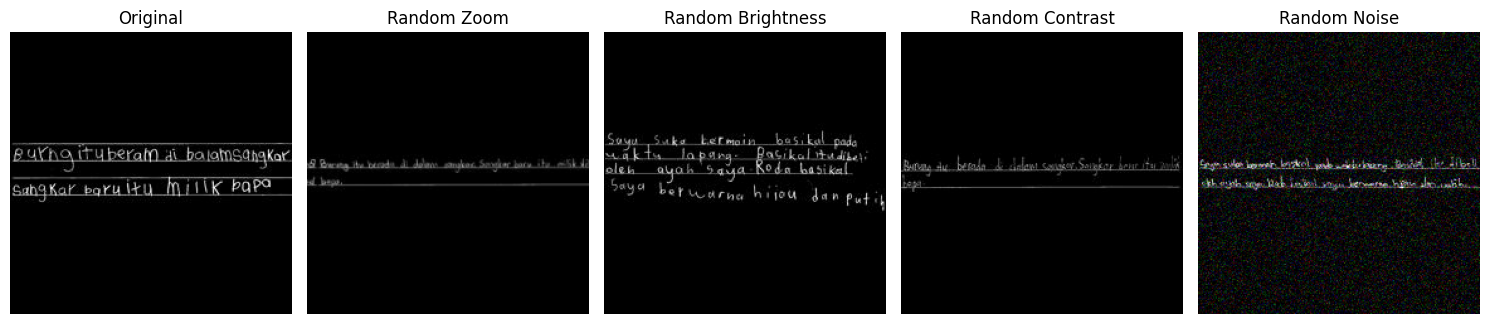

Training Set:
Low Potential Dysgraphia: 540
Potential Dysgraphia: 460

Validation (Testing) Set:
Low Potential Dysgraphia: 27
Potential Dysgraphia: 22


In [ ]:
# Data Augmentation

# Define individual data augmentation techniques
random_zoom = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.5)
])

random_brightness = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.8))
])

random_contrast = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.image.random_contrast(x, lower=0.7, upper=1.0))
])

# Custom layer for adding random noise
class AddRandomNoise(layers.Layer):
    def __init__(self, noise_factor, **kwargs):
        super(AddRandomNoise, self).__init__(**kwargs)
        self.noise_factor = noise_factor

    def call(self, inputs, training=True):
        if training:
            noise = tf.random.normal(tf.shape(inputs), stddev=self.noise_factor)
            inputs = inputs + noise
            inputs = tf.clip_by_value(inputs, 0.0, 255.0)  # Clip to valid pixel range
        return inputs

# Apply each data augmentation technique separately
augmented_zoom_ds_train = train_ds.map(lambda x, y: (random_zoom(x, training=True), y))
augmented_brightness_ds_train = train_ds.map(lambda x, y: (random_brightness(x, training=True), y))
augmented_contrast_ds_train = train_ds.map(lambda x, y: (random_contrast(x, training=True), y))
augmented_noise_ds_train = train_ds.map(lambda x, y: (AddRandomNoise(30)(x, training=True), y))  # Adjust noise_factor as needed
# Merge the original and augmented datasets

merged_train_ds = train_ds.concatenate(
    augmented_zoom_ds_train
).concatenate(
    augmented_brightness_ds_train
).concatenate(
    augmented_contrast_ds_train
).concatenate(
    augmented_noise_ds_train
)

# Visualize one augmented image per technique
plt.figure(figsize=(15, 5))

# Original
for images, labels in train_ds.take(1):
    plt.subplot(1, 5, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title('Original')
    plt.axis("off")

# Zoom augmentation
for images, labels in augmented_zoom_ds_train.take(1):
    plt.subplot(1, 5, 2)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title('Random Zoom')
    plt.axis("off")

# Brightness augmentation
for images, labels in augmented_brightness_ds_train.take(1):
    plt.subplot(1, 5, 3)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title('Random Brightness')
    plt.axis("off")

# Contrast augmentation
for images, labels in augmented_contrast_ds_train.take(1):
    plt.subplot(1, 5, 4)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title('Random Contrast')
    plt.axis("off")

# Noise augmentation
for images, labels in augmented_noise_ds_train.take(1):
    plt.subplot(1, 5, 5)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title('Random Noise')
    plt.axis("off")

plt.tight_layout()
plt.show()

def count_samples_by_class(dataset):
    class_counts = {0: 0, 1: 0}  # Assuming 0 for Low Potential and 1 for Potential
    for _, labels in dataset.unbatch():
        class_index = tf.argmax(labels).numpy()  # Get the class index
        class_counts[class_index] += 1
    return class_counts

# Count for training set
train_counts = count_samples_by_class(merged_train_ds)
print("Training Set:")
print("Low Potential Dysgraphia:", train_counts[0])
print("Potential Dysgraphia:", train_counts[1])

# Count for validation (testing) set
val_counts = count_samples_by_class(val_ds)
print("\nValidation (Testing) Set:")
print("Low Potential Dysgraphia:", val_counts[0])
print("Potential Dysgraphia:", val_counts[1])

## ✅**Building the Model**

<ipython-input-15-8d5747bfcdc5>:286: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


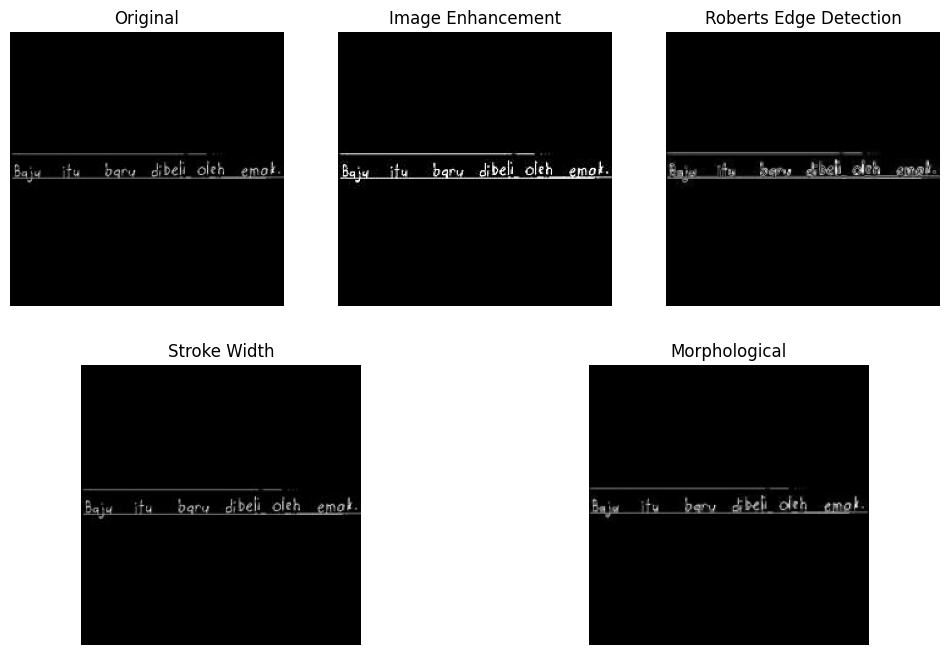

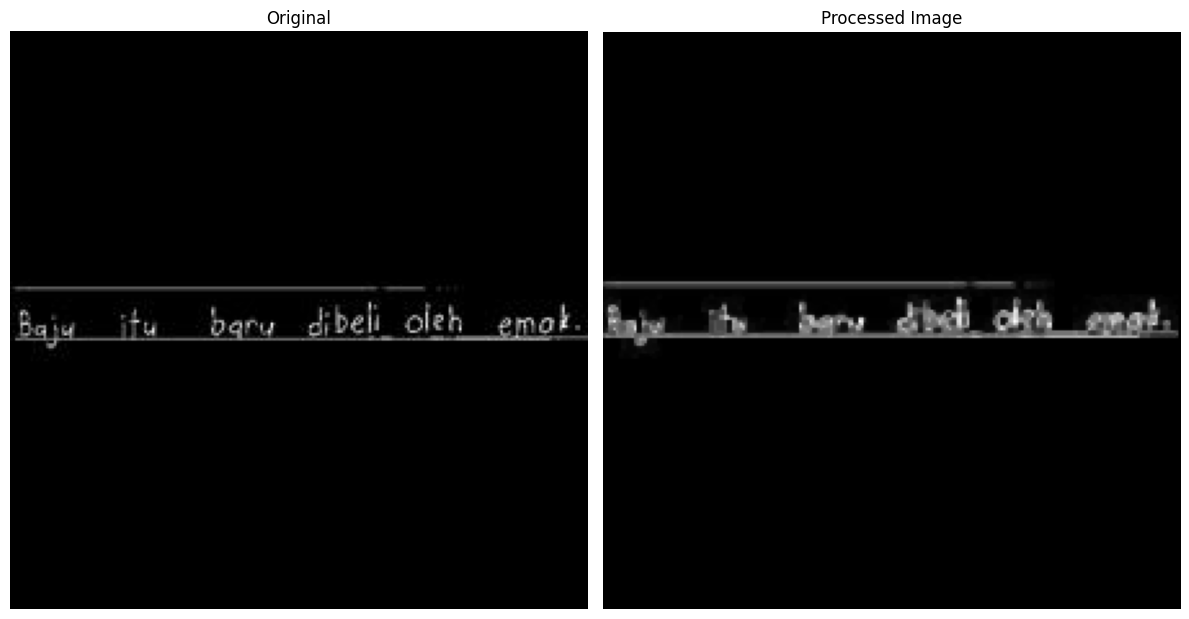

In [ ]:
# Define image size
image_size = (224, 224)


# IMAGE ENHANCEMENT -------------------------------------------------------------------------------
class ImageEnhancementLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(ImageEnhancementLayer, self).__init__(**kwargs)

    def call(self, inputs, training=None):
        if tf.executing_eagerly():
            # Eager execution (for testing/visualization)
            img = tf.keras.preprocessing.image.array_to_img(inputs[0])  # Use inputs[0] to access the first image in the batch

            # Apply PIL-based enhancements
            brightness_factor = 1 + (34 / 100)
            x_enhanced = ImageEnhance.Brightness(img).enhance(brightness_factor)
            contrast_factor = 1 + (30 / 100)
            x_enhanced = ImageEnhance.Contrast(x_enhanced).enhance(contrast_factor)
            sharpness_factor = 1 + (70 / 100)
            x_enhanced = ImageEnhance.Sharpness(x_enhanced).enhance(sharpness_factor)
            x_enhanced = x_enhanced.filter(ImageFilter.MedianFilter(size=1))

            # Convert back to tensor
            x_enhanced = tf.keras.preprocessing.image.img_to_array(x_enhanced)
            x_enhanced = tf.expand_dims(x_enhanced, 0)
        else:
            # Training path (use TensorFlow image operations)
            x_enhanced = tf.image.adjust_brightness(inputs, 0.34)
            x_enhanced = tf.image.adjust_contrast(x_enhanced, 1.3)
            x_enhanced = tf.image.adjust_saturation(x_enhanced, 1.7)
            x_enhanced = tf.clip_by_value(x_enhanced, 0, 255)

        return x_enhanced

    def compute_output_shape(self, input_shape):
        return input_shape

# EDGE DETECTION -------------------------------------------------------------------------------

class RobertsLayer(layers.Layer):
    def call(self, inputs):
        # Convert inputs to float32
        inputs_float32 = tf.cast(inputs, tf.float32)

        # Check the number of channels
        num_channels = inputs.shape[-1]

        # Define Roberts Cross kernels
        kernel_x = tf.constant([[1, 0], [0, -1]], dtype=tf.float32)
        kernel_y = tf.constant([[0, 1], [-1, 0]], dtype=tf.float32)

        # Reshape kernels to match the number of input channels
        kernel_x = tf.reshape(kernel_x, [2, 2, 1, 1])
        kernel_y = tf.reshape(kernel_y, [2, 2, 1, 1])

        # Apply convolution using Roberts Cross kernels for each channel
        grad_x = [tf.nn.conv2d(inputs_float32[..., i:i+1], kernel_x, strides=[1, 1, 1, 1], padding='SAME') for i in range(num_channels)]
        grad_y = [tf.nn.conv2d(inputs_float32[..., i:i+1], kernel_y, strides=[1, 1, 1, 1], padding='SAME') for i in range(num_channels)]

        # Concatenate the gradients along the channel dimension (if more than one channel)
        grad_x = tf.concat(grad_x, axis=-1)
        grad_y = tf.concat(grad_y, axis=-1)

        # Compute the gradient magnitude
        grad_magnitude = tf.sqrt(tf.square(grad_x) + tf.square(grad_y))

        # Normalize the gradient magnitudes
        grad_magnitude /= tf.reduce_max(grad_magnitude)

        # Return the result with the same number of channels as input
        return grad_magnitude

    def compute_output_shape(self, input_shape):
        return input_shape



# STROKE WIDTH FILTER -------------------------------------------------------------------------------

class StrokeWidthLayer(layers.Layer):
    def call(self, sobel_output):
        # Ensure the input is from the SobelLayer
        if sobel_output.shape[-1] != 1:
            raise ValueError("Input must be the output of SobelLayer with 1 channel.")

        # Calculate the stroke width from the Sobel output
        # Here, we can compute the average or apply some additional processing
        stroke_width = tf.reduce_mean(sobel_output, axis=-1, keepdims=True)  # Example calculation

        # Normalize the stroke width
        normalized_stroke_width = stroke_width / (tf.reduce_max(stroke_width) + 1e-8)

        return normalized_stroke_width  # Output shape: (batch_size, height, width, 1)

    def compute_output_shape(self, input_shape):
        return input_shape  # Ensure output shape matches input shape



# MORPHOLOGICAL -------------------------------------------------------------------------------

class MorphologicalLayer(layers.Layer):
    def __init__(self, kernel_size=(2, 2), **kwargs):
        super(MorphologicalLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def call(self, inputs):
        # Ensure inputs have the shape (batch_size, height, width, 1) for grayscale
        if inputs.shape[-1] != 1:
            raise ValueError("Input must be a grayscale image with a single channel.")

        # Define the kernel for dilation and erosion
        kernel = tf.ones(self.kernel_size + (1,), dtype=tf.float32)

        # Perform dilation
        dilated_image = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.kernel_size[0], self.kernel_size[1], 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='SAME'
        )
        dilated_image = tf.reduce_max(dilated_image, axis=-1, keepdims=True)

        # Perform erosion
        eroded_image = tf.image.extract_patches(
            images=dilated_image,
            sizes=[1, self.kernel_size[0], self.kernel_size[1], 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='SAME'
        )
        eroded_image = tf.reduce_min(eroded_image, axis=-1, keepdims=True)

        return eroded_image

    def compute_output_shape(self, input_shape):
        return input_shape  # Ensure output shape matches input shape

# COLOR CONVERSIONS ------------------------------------------------------------------------
class GrayscaleToRGBLayer(layers.Layer):
    def __init__(self, target_size=(224, 224), **kwargs):
        super(GrayscaleToRGBLayer, self).__init__(**kwargs)
        self.target_size = target_size

    def call(self, inputs):
        # Ensure inputs have the shape (batch_size, height, width, 1)
        if inputs.shape[-1] != 1:
            raise ValueError("Input must be a grayscale image with a single channel.")

        # Resize the image to the target size
        resized_image = tf.image.resize(inputs, self.target_size)

        # Convert grayscale image to RGB by duplicating the single channel
        rgb_image = tf.image.grayscale_to_rgb(resized_image)

        return rgb_image

    def compute_output_shape(self, input_shape):
        # Convert grayscale (batch_size, height, width, 1) to RGB (batch_size, height, width, 3)
        return (input_shape[0], self.target_size[0], self.target_size[1], 3)

class RGBToGrayscaleLayer(layers.Layer):
    def __init__(self, target_size=(224, 224), **kwargs):
      super(RGBToGrayscaleLayer, self).__init__(**kwargs) # Use RGBToGrayscaleLayer instead of GrayscaleToRGBLayer
      self.target_size = target_size

    def call(self, inputs):
        # Ensure inputs have the shape (batch_size, height, width, 3)
        if inputs.shape[-1] != 3:
            raise ValueError("Input must be an RGB image with 3 channels.")

        # Convert RGB image to grayscale
        grayscale_image = tf.image.rgb_to_grayscale(inputs)

        return grayscale_image

    def compute_output_shape(self, input_shape):
        # Convert RGB (batch_size, height, width, 3) to Grayscale (batch_size, height, width, 1)
        return (input_shape[0], input_shape[1], input_shape[2], 1)

class SqueezeLayer(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super(SqueezeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        print(f"Shape before squeezing: {inputs.shape}")
        squeezed = tf.squeeze(inputs, axis=self.axis)  # Remove extra dimensions
        print(f"Shape after squeezing: {squeezed.shape}")

        # If squeezed shape has 3 dimensions and we have grayscale images, restore the channel dimension
        if len(squeezed.shape) == 3:  # (batch, height, width) for grayscale image
            restored = tf.expand_dims(squeezed, axis=-1)  # (batch_size, 224, 224, 1)
        else:
            restored = squeezed  # No expansion needed, already 4D

        print(f"Shape after restoring channel dimension: {restored.shape}")

        return restored


# VGG16 architecture with morphological operation after stroke width filter ----------------------------------------------------
def create_model():
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=image_size + (3,))
    vgg16_base.trainable = False

    inputs = tf.keras.Input(shape=image_size + (3,))
    #x = ImageEnhancementLayer()(inputs)
    x = RGBToGrayscaleLayer()(inputs)
    x = RobertsLayer()(x)
    x = StrokeWidthLayer()(x)
    x = SqueezeLayer(axis=-1)(x)

    x = MorphologicalLayer(kernel_size=(2,2))(x)
    x = GrayscaleToRGBLayer()(x)
    # Pass input through VGG16 base model
    x = vgg16_base(x, training=False)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    num_classes = 2
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
                 loss="categorical_crossentropy",
                  metrics=["accuracy", 'precision'])

    return model



#  Visualization -------------------------------------------------------------------------------
# Display the images in subplots: before and after image enhancement, edge detection, stroke width filter, morphological
def visualize_part(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Create a figure with 1 row and 3 columns, then 1 row with 2 columns
    fig = plt.figure(figsize=(12, 8))

    # 1st row: 3 columns
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(img)
    ax1.set_title('Original')
    ax1.axis("off")

    x = ImageEnhancementLayer()(img_array)
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.imshow(x[0].numpy().astype("uint8"))
    ax2.set_title('Image Enhancement')
    ax2.axis("off")

    x = RGBToGrayscaleLayer()(img_array)
    x = RobertsLayer()(x)
    x = tf.squeeze(x, axis=0)
    x = tf.squeeze(x, axis=-1)
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.imshow(x, cmap='gray')
    ax3.set_title('Roberts Edge Detection')
    ax3.axis('off')

    # 2nd row: 2 columns
    x = RGBToGrayscaleLayer()(img_array)
    x = StrokeWidthLayer()(x)
    x = tf.squeeze(x, axis=0)
    x = tf.squeeze(x, axis=-1)
    ax4 = fig.add_subplot(2, 2, 3)  # Positioned in the first column of the second row
    ax4.imshow(x, cmap='gray')
    ax4.set_title('Stroke Width')
    ax4.axis('off')

    x = RGBToGrayscaleLayer()(img_array)
    x = MorphologicalLayer()(x)
    x = GrayscaleToRGBLayer()(x)
    ax5 = fig.add_subplot(2, 2, 4)  # Positioned in the second column of the second row
    ax5.imshow(tf.squeeze(x[0]).numpy().astype("uint8"))
    ax5.set_title('Morphological')
    ax5.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage with the first image from low_potential_dir
visualize_part(low_potential_dir + "/LPD (1).jpg")


def visualize_all(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    # Original Image
    axs[0].imshow(img)
    axs[0].set_title('Original')
    axs[0].axis("off")
    #ImgEnhance + Roberts + SWF
    # Processed Image
    #x = ImageEnhancementLayer()(img_array)
    x = RGBToGrayscaleLayer()(img_array)  # Convert to grayscale (Shape: (1, 224, 224, 1))
    x = RobertsLayer()(x)          # Apply Roberts Layer (Shape: (1, 224, 224, 1))
    x = StrokeWidthLayer()(x)      # Apply Stroke Width Layer (Shape: (1, 224, 224, 1))

    # Ensure the input to MorphologicalLayer has a single grayscale channel
    x = MorphologicalLayer()(x)    # Morphological operation (Shape: (1, 224, 224, 1))
    x = GrayscaleToRGBLayer()(x)   # Convert back to RGB (Shape: (1, 224, 224, 3))
    x = tf.squeeze(x, axis=0)      # Remove the batch dimension for display (Shape: (224, 224, 3))

    axs[1].imshow(x)
    axs[1].set_title('Processed Image')
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


# Example usage with the first image from low_potential_dir
visualize_all(low_potential_dir + "/LPD (1).jpg")



**Confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm):
    # Create a heatmap for visualization with custom labels
    sns.heatmap(cm, annot=True, fmt='g', cmap='Pastel1',
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'])

    # Modify axis labels
    plt.title('Confusion Matrix')
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')

    # Customize the tick labels for True Positives, False Positives, True Negatives, False Negatives
    plt.text(0.5, 0.3, f'True Negatives', ha='center', va='center', color='black')
    plt.text(0.5, 1.3, f'False Positives', ha='center', va='center', color='black')
    plt.text(1.5, 0.3, f'False Negatives', ha='center', va='center', color='black')
    plt.text(1.5, 1.3, f'True Positives', ha='center', va='center', color='black')

    plt.show()

**Building the Model**

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shape before squeezing: (None, 224, 224, 1)
Shape after squeezing: (None, 224, 224)
Shape after restoring channel dimension: (None, 224, 224, 1)
Epoch 1/15
Shape before squeezing: (None, 224, 224, 1)
Shape after squeezing: (None, 224, 224)
Shape after restoring channel dimension: (None, 224, 224, 1)
Shape before squeezing: (None, 224, 224, 1)
Shape after squeezing: (None, 224, 224)
Shape after restoring channel dimension: (None, 224, 224, 1)
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5281 - loss: 38.4790 - precision: 0.5281 Shape before squeezing: (None, 224, 224, 1)
Shape after squeezing: (None, 224, 224)
Shape after restoring channel dimension: (None, 224, 224, 1)
Shape before squeezing: (16, 224, 224, 1)
Shape after squeezing: (16, 224, 224)
Shape after restoring channel dimension: (16, 224, 224, 1)
3/4 ━━━━━━━━━━━━━━━━━━━━ 10s 11s/stepShape before squeezing: (None, 224, 224, 1)
Shape after squeezing: (None, 224, 224)
Shap

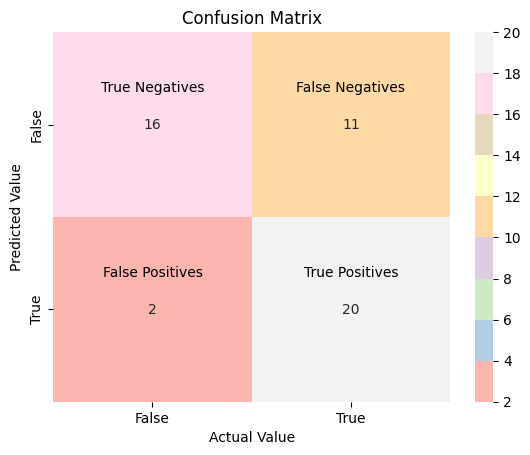

Model saved to /content/drive/Shared drives/CS FILES/Model/vgg16_roberts_model.h5


In [ ]:
# Define callbacks to monitor metrics and time taken per epoch
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super(MetricsCallback, self).__init__()
        self.val_data = val_data
        self.highest_accuracy_epoch = -1
        self.highest_accuracy = 0
        self.epoch_times = []
        self.results = []

    def on_epoch_begin(self, epoch, logs=None):
        # Record the start time of the epoch
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Calculate time taken for this epoch
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

        # Time the classification process
        classification_start_time = time.time()
        val_predictions = self.model.predict(self.val_data)
        classification_time = time.time() - classification_start_time
        classification_time_rounded =  round(classification_time / 60, 4)

        val_predictions = self.model.predict(self.val_data)
        val_labels = tf.concat([y for x, y in self.val_data], axis=0)
        val_predictions = tf.argmax(val_predictions, axis=1)
        val_labels = tf.argmax(val_labels, axis=1)

        # Metrics from built in module
        precision = round(precision_score(val_labels, val_predictions, zero_division=1), 4)
        recall = round(recall_score(val_labels, val_predictions, zero_division=1), 4)
        f1 = round(f1_score(val_labels, val_predictions, zero_division=1), 4)
        testing_accuracy = round(accuracy_score(val_labels, val_predictions), 4)
        testing_accuracy_logs = round(logs['val_accuracy'], 4)
        training_loss = round(logs['loss'], 4)
        testing_loss = round(logs['val_loss'], 4)
        training_accuracy = round(logs['accuracy'], 4)

        # True Positive, True Negative, False Positive, False Negative
        tp = np.sum(np.logical_and(val_labels == 1, val_predictions == 1))
        tn = np.sum(np.logical_and(val_labels == 0, val_predictions == 0))
        fp = np.sum(np.logical_and(val_labels == 0, val_predictions == 1))
        fn = np.sum(np.logical_and(val_labels == 1, val_predictions == 0))

        # Manually compute metrics
        comp_prec = round(tp / (tp + fp + 1e-6), 4)
        comp_acc = round((tp + tn) / (tp + tn + fp + fn + 1e-6), 4)
        comp_rec = round(tp / (tp + fn + 1e-6), 4)
        comp_f1 = round(2 * (comp_prec * comp_rec) / (comp_prec + comp_rec + 1e-6), 4)

        metrics_data = {
            'Epoch': [epoch + 1],
            'Precision': [comp_prec],
            'Accuracy': [testing_accuracy],
            'Recall': [recall],
            'F1 Score': [f1],
            'Classification Time (min)': [classification_time_rounded],
            'Training Accuracy': [training_accuracy],
            'Training Loss': [training_loss],
            'Testing Loss': [testing_loss]
        }

        # Display Metrics Table
        metrics_df = pd.DataFrame(metrics_data)
        print('\n')
        print(tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False))

        # Checking
        print('\nMANUAL COMPUTATION:')
        print(f'Epoch {epoch + 1} - Precision: {comp_prec}  | Accuracy: {comp_acc}  | Recall: {comp_rec}  | F1 Score: {comp_f1} | Classification Time: {classification_time / 60:.4f} mins')
        print(f"\nTime taken for epoch {epoch + 1}: {epoch_time:.2f} seconds")
        print(f"tp: {tp}, tn = {tn}, fp: {fp}, fn: {fn}\n")

        # Append metrics data to the results list
        self.results.append(metrics_data)

    def get_metrics_df(self):
        # Convert the results list to a DataFrame
        metrics_df = pd.DataFrame(self.results)
        return metrics_df

# Create the final model
final_model = create_model()

# Define EarlyStopping with patience of 3
early_stopping = EarlyStopping(
    monitor='precision',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

val_callback = MetricsCallback(val_ds)
callbacks = [val_callback, early_stopping]

# Train the final model
epochs = 15
history = final_model.fit(merged_train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, verbose=1)

# Check if early stopping triggered
if early_stopping.stopped_epoch > 0:
    print(f"Early stopping triggered after {early_stopping.stopped_epoch + 1} epochs.")

metrics_all_df = val_callback.get_metrics_df()
print('\nMetrics in all Epochs')
print(tabulate(metrics_all_df, headers='keys', tablefmt='pretty', showindex=False))

# Average
print('\nAverage')
for column in metrics_all_df.columns[1:]:
    # Access the first element of the list in each cell
    avg_value = metrics_all_df[column].apply(lambda x: x[0]).mean()
    print(f"Average {column}: {avg_value:.4f}")

# Plot the confusion matrix for the last epoch
val_predictions = final_model.predict(val_ds)
val_labels = tf.concat([y for x, y in val_ds], axis=0)
val_predictions = tf.argmax(val_predictions, axis=1)
val_labels = tf.argmax(val_labels, axis=1)
cm = confusion_matrix(val_labels, val_predictions)
plot_confusion_matrix(cm)

# Save the Model
model_path = "/content/drive/Shared drives/CS FILES/Model/vgg16_roberts_model.h5"
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the model
final_model.save(model_path)
print(f"Model saved to {model_path}")

In [ ]:
print('\nAverage')
for column in metrics_all_df.columns[1:]:
    # Access the first element of the list in each cell
    avg_value = metrics_all_df[column].apply(lambda x: x[0]).mean()
    print(f"Average {column}: {avg_value:.4f}")


Average
Average Precision: 0.8233
Average Accuracy: 0.7872
Average Recall: 0.7013
Average F1 Score: 0.7403
Average Classification Time (min): 0.5959
Average Training Accuracy: 0.8068
Average Training Loss: 1.3609
Average Testing Loss: 0.5299


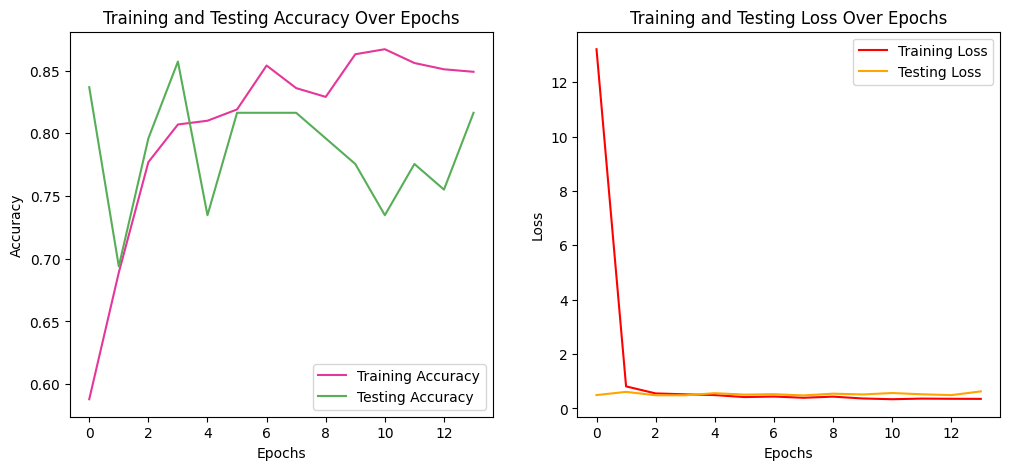

In [ ]:
# Plot training and testing accuracy/loss
def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 5))

    # Subplot 1 - Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='#E5369A')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy', color='#56AE57')
    plt.title('Training and Testing Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Subplot 2 - Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    plt.plot(history.history['val_loss'], label='Testing Loss', color='orange')
    plt.title('Training and Testing Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# Call plot function
plot_training_history(history)

## ✅**Classification**

In [ ]:
# Define the file paths for the images
lowpotential_image_paths = [
    low_potential_dir + "/LPD (1).jpg",
    low_potential_dir + "/LPD (70).jpg",
    low_potential_dir + "/LPD (135).jpg"
]

potential_image_paths = [
    potential_dir + "/PD (1).jpg",
    potential_dir + "/PD (52).jpg",
    potential_dir + "/PD (114).jpg"
]


# Define a function to load and predict on an image
def load_and_predict(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = final_model.predict(img_array)
    return predictions

# Iterate over the image paths for each hair class
print("LOW POTENTIAL DYSGRAPHIA PREDICTIONS")
for path in lowpotential_image_paths:
    predictions = load_and_predict(path)
    print("This image is %.2f Low Potential Dysgraphia, %.2f percent Potential Dysgraphia."
          % tuple(predictions[0]))

print("\nPOTENTIAL DYSGRAPHIA PREDICTIONS")
for path in potential_image_paths:
    predictions = load_and_predict(path)
    print("This image is %.2f Low Potential Dysgraphia, %.2f percent Potential Dysgraphia."
          % tuple(predictions[0]))


LOW POTENTIAL DYSGRAPHIA PREDICTIONS
Shape before squeezing: (1, 224, 224, 1)
Shape after squeezing: (1, 224, 224)
Shape after restoring channel dimension: (1, 224, 224, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image is 0.57 Low Potential Dysgraphia, 0.43 percent Potential Dysgraphia.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image is 0.53 Low Potential Dysgraphia, 0.47 percent Potential Dysgraphia.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image is 0.23 Low Potential Dysgraphia, 0.77 percent Potential Dysgraphia.

POTENTIAL DYSGRAPHIA PREDICTIONS
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
This image is 0.11 Low Potential Dysgraphia, 0.89 percent Potential Dysgraphia.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
This image is 0.08 Low Potential Dysgraphia, 0.92 percent Potential Dysgraphia.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image is 0.00 Low Potential Dysgraphia, 1.00 percent Potential Dysgraphia.


## ✅**GUI**

In [1]:
# Load the pre-trained model
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
!pip install gradio
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras import layers
from PIL import Image, ImageEnhance, ImageFilter


from google.colab import drive
from pathlib import Path

# Mounting the drive

drive.flush_and_unmount()
drive.mount('/content/drive')

def pad_and_resize(image, target_size=(224, 224)):
    width, height = image.size
    longer_side = max(width, height)
    horizontal_padding = (longer_side - width) // 2
    vertical_padding = (longer_side - height) // 2

    padded_image = Image.new(image.mode, (longer_side, longer_side), color='black')
    padded_image.paste(image, (horizontal_padding, vertical_padding))

    # Resize the padded image to the target size with anti-aliasing
    padded_image_resized = padded_image.resize(target_size)

    return padded_image_resized


class RGBToGrayscaleLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return tf.image.rgb_to_grayscale(inputs)


class GrayscaleToRGBLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        # Ensure input has a channel dimension
        if inputs.shape.rank == 3:  # Shape: (None, 224, 224)
            inputs = tf.expand_dims(inputs, axis=-1)  # Shape: (None, 224, 224, 1)
        return tf.image.grayscale_to_rgb(inputs)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (3,)  # Output has 3 channels

# Define ImageEnhancementLayer
class ImageEnhancementLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        if tf.executing_eagerly():
            # PIL-based enhancements (for debugging and visualization)
            img = tf.keras.preprocessing.image.array_to_img(inputs[0])  # Access first image in batch
            brightness_factor = 1 + (34 / 100)
            x_enhanced = ImageEnhance.Brightness(img).enhance(brightness_factor)
            contrast_factor = 1 + (30 / 100)
            x_enhanced = ImageEnhance.Contrast(x_enhanced).enhance(contrast_factor)
            sharpness_factor = 1 + (70 / 100)
            x_enhanced = ImageEnhance.Sharpness(x_enhanced).enhance(sharpness_factor)
            x_enhanced = x_enhanced.filter(ImageFilter.MedianFilter(size=1))

            # Convert back to tensor
            x_enhanced = tf.keras.preprocessing.image.img_to_array(x_enhanced)
            x_enhanced = tf.expand_dims(x_enhanced, 0)  # Restore batch dimension
            x_enhanced = tf.cast(x_enhanced, inputs.dtype)
        else:
            # Placeholder for TensorFlow-based enhancements during training
            x_enhanced = inputs
        return x_enhanced

# Define StrokeWidthLayer
class StrokeWidthLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        # Placeholder for stroke width computation logic
        return inputs


class RobertsLayer(layers.Layer):
    def call(self, inputs):
        # Convert inputs to float32
        inputs_float32 = tf.cast(inputs, tf.float32)

        # Check the number of channels
        num_channels = inputs.shape[-1]

        # Define Roberts Cross kernels
        kernel_x = tf.constant([[1, 0], [0, -1]], dtype=tf.float32)
        kernel_y = tf.constant([[0, 1], [-1, 0]], dtype=tf.float32)

        # Reshape kernels to match the number of input channels
        kernel_x = tf.reshape(kernel_x, [2, 2, 1, 1])
        kernel_y = tf.reshape(kernel_y, [2, 2, 1, 1])

        # Apply convolution using Roberts Cross kernels for each channel
        grad_x = [tf.nn.conv2d(inputs_float32[..., i:i+1], kernel_x, strides=[1, 1, 1, 1], padding='SAME') for i in range(num_channels)]
        grad_y = [tf.nn.conv2d(inputs_float32[..., i:i+1], kernel_y, strides=[1, 1, 1, 1], padding='SAME') for i in range(num_channels)]

        # Concatenate the gradients along the channel dimension (if more than one channel)
        grad_x = tf.concat(grad_x, axis=-1)
        grad_y = tf.concat(grad_y, axis=-1)

        # Compute the gradient magnitude
        grad_magnitude = tf.sqrt(tf.square(grad_x) + tf.square(grad_y))

        # Normalize the gradient magnitudes
        grad_magnitude /= tf.reduce_max(grad_magnitude)

        # Return the result with the same number of channels as input
        return grad_magnitude

    def compute_output_shape(self, input_shape):
        return input_shape

class MorphologicalLayer(layers.Layer):
    def __init__(self, kernel_size=(2, 2), **kwargs):
        super(MorphologicalLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def call(self, inputs):
        # Ensure inputs have the shape (batch_size, height, width, 1) for grayscale
        if inputs.shape[-1] != 1:
            raise ValueError("Input must be a grayscale image with a single channel.")

        # Define the kernel for dilation and erosion
        kernel = tf.ones(tuple(self.kernel_size) + (1,), dtype=tf.float32)

        # Perform dilation
        dilated_image = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.kernel_size[0], self.kernel_size[1], 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='SAME'
        )
        dilated_image = tf.reduce_max(dilated_image, axis=-1, keepdims=True)

        # Perform erosion
        eroded_image = tf.image.extract_patches(
            images=dilated_image,
            sizes=[1, self.kernel_size[0], self.kernel_size[1], 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='SAME'
        )
        eroded_image = tf.reduce_min(eroded_image, axis=-1, keepdims=True)
        return eroded_image

    def compute_output_shape(self, input_shape):
        return input_shape  # Ensure output shape matches input shape


class SqueezeLayer(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super(SqueezeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        squeezed = tf.squeeze(inputs, axis=self.axis)  # Remove extra dimensions

        # If squeezed shape has 3 dimensions and we have grayscale images, restore the channel dimension
        if len(squeezed.shape) == 3:  # (batch, height, width) for grayscale image
            restored = tf.expand_dims(squeezed, axis=-1)  # (batch_size, 224, 224, 1)
        else:
            restored = squeezed  # No expansion needed, already 4D

        return restored

# Load the model with custom_object_scope
with keras.utils.custom_object_scope({
    'RGBToGrayscaleLayer': RGBToGrayscaleLayer,
    'RobertsLayer': RobertsLayer,  # Add other custom layers here
    'StrokeWidthLayer': StrokeWidthLayer,
    'SqueezeLayer': SqueezeLayer,
    'MorphologicalLayer': MorphologicalLayer,
    'GrayscaleToRGBLayer': GrayscaleToRGBLayer
}):
    final_model = load_model("/content/drive/Shared drives/CS FILES/Model/vgg16_roberts_model.h5")

# Define the class labels
class_labels = ["Low Potential Dysgraphia", "Potential Dysgraphia"]

# Diagnostic messages for each class
diagnostic_messages = {
    "Low Potential Dysgraphia": "It suggests a minimal impairment in writing; however, observing difficulty in hand grip and positioning may still be beneficial.",
    "Potential Dysgraphia": "It is highly recommended to consult a specialist for further evaluation and support."
}

# Define the image size (update based on your model's input size)
image_size = (224, 224)

# Preprocess the uploaded image
def preprocess_image(img):
    try:
        img = img.resize(image_size)  # Resize the image to match model input size
        img_array = np.array(img)     # Convert image to NumPy array

        # Handle RGBA images by dropping the alpha channel if present
        if img_array.shape[-1] == 4:
            img_array = img_array[..., :3]  # Drop the alpha channel

        img_array = np.expand_dims(img_array, 0) / 255.0  # Add batch dimension and normalize
        return img_array
    except Exception as e:
        raise ValueError(f"Error in preprocessing image: {e}")

# Function to make prediction based on the uploaded image
def predict_image(img):
    try:
        img_array = preprocess_image(img)
        predictions = final_model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])

        # Optionally, log predictions for debugging
        print(f"Prediction probabilities: {predictions[0]}")

        class_label = class_labels[predicted_class_index]
        diagnostic_prompt = diagnostic_messages[class_label]
        return f"This handwriting is \"{class_label}\".\n\n{diagnostic_prompt}"

    except Exception as e:
        return f"Error in making prediction: {e}"

# Create Gradio interface
title = "Dysgraphia Classification using VGG16 Architecture with Roberts Edge Detection in an Offline Handwriting Analysis"
description = (
    "Upload an image, and the model will predict if it indicates "
    "Low Potential Dysgraphia or Potential Dysgraphia."
)

gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),  # Input expects a PIL image
    outputs=gr.Text(),            # Output will be displayed as text
    title=title,
    description=description
).launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://027f0abc0d0ccaad19.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
